## Import modules

In [13]:
from collections import deque
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC

## Download attendance data

In [16]:
url = "https://football-web-pages1.p.rapidapi.com/attendances.json"
querystring = {}

headers = {
	"X-RapidAPI-Key": "...",
	"X-RapidAPI-Host": "football-web-pages1.p.rapidapi.com"
}

response = requests.get(url, headers=headers)# params=querystring)

print(response.json())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Data preprocessing functions

This includes
- Converting dates to timestamps
- Calculating all the Gustas things for the previous _n_ games

In [3]:
METRICS = {
    "GoalsFullTime": ("FTHG", "FTAG"),
    "GoalsHalfTime": ("HTHG", "HTAG"),
    "GustasPoints":  ("HomePoints", "AwayPoints"),
    "GoalShots":     ("HS",   "AS"),
    "TargetShots":   ("HST",  "AST"),
    "Fouls":         ("HF",   "AF"),
    "Corners":       ("HC",   "AC"),
    "YellowCards":   ("HY",   "AY"),
    "RedCards":      ("HR",   "AR")
}


def create_date_stamp(date_string: str) -> int:
    # Transforms a dd/mm/yy or dd/mm/yyyy string to a timestamp
    if len(date_string.split("/")[-1]) == 4:
        return int(datetime.strptime(date_string, "%d/%m/%Y").timestamp())
    else:
        return int(datetime.strptime(date_string, "%d/%m/%y").timestamp())


def group_seasons(df: pd.DataFrame) -> np.array:
    # Adds a column to the df indicating which season it is
    seasons = []
    season_counter = 1
    prev_season_index = 0
    rows = df.iterrows()
    next(rows)

    for i, game in rows:
        curr_game_month = int(game.Date[4])
        prev_game_month = int(df.iloc[i - 1].Date[4])

        if curr_game_month - prev_game_month > 1:
            seasons += [season_counter]*(i - prev_season_index)
            season_counter += 1
            prev_season_index = i

    return pd.DataFrame({"Season": seasons})


def generate_gustas_points(df: pd.DataFrame) -> pd.DataFrame:
    # Caluclate Gustas' points for each game
    points = {"HomePoints": [0]*len(df), "AwayPoints": [0]*len(df)}
    score_map = {"H": (3, 0), "A": (0, 3), "D": (1, 1)}

    for i, (_, game) in enumerate(df.iterrows()):
        points["HomePoints"][i], points["AwayPoints"][i] = score_map[game["FTR"]]

    return pd.DataFrame(points)


# Generating game-specific data #


def calculate_window_metrics_by_team(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # Calculates each metric for each team over the last n values
    global METRICS

    teams = df["HomeTeam"].unique()
    team_metric_deques = {t : {m : [0, deque([], maxlen=n)] for m in METRICS} for t in teams}
    metrics_df = {}

    # Fill columns
    for metric in METRICS:
        metrics_df[f"HomeLNG{metric}"] = []
        metrics_df[f"AwayLNG{metric}"] = []

    for _, game in df.iterrows():
        home = game.HomeTeam
        away = game.AwayTeam

        for metric in METRICS:
            home_metric, away_metric = METRICS[metric]

            # Add existing data to df
            home_metric_sum, home_deque = team_metric_deques[home][metric]
            away_metric_sum, away_deque = team_metric_deques[away][metric]

            if len(home_deque) == 0:
                metrics_df[f"HomeLNG{metric}"].append(float("NaN"))
            else:
                metrics_df[f"HomeLNG{metric}"].append(home_metric_sum / len(home_deque))

            if len(away_deque) == 0:
                metrics_df[f"AwayLNG{metric}"].append(float("NaN"))
            else:
                metrics_df[f"AwayLNG{metric}"].append(away_metric_sum / len(away_deque))

            # Include new data
            if len(home_deque) == n:
                team_metric_deques[home][metric][0] -= home_deque[0]
            
            if len(away_deque) == n:
                team_metric_deques[away][metric][0] -= away_deque[0]

            team_metric_deques[home][metric][0] += game[home_metric]
            team_metric_deques[home][metric][1].append(game[home_metric])

            team_metric_deques[away][metric][0] += game[away_metric]
            team_metric_deques[away][metric][1].append(game[away_metric])

    return pd.DataFrame(metrics_df)



# Only the below function should be used directly #


def format_df(df: pd.DataFrame) -> pd.DataFrame:
    # Applies all feature engineering etc that one could want
    df["DateStamp"] = df["Date"].map(create_date_stamp)
    df = df.join(group_seasons(df))
    df = df.join(generate_gustas_points(df))
    df = df.join(calculate_window_metrics_by_team(df, 10))

    return df
    

## Load training and testing data

In [18]:
# Define features etc
FEATURES = [
    "HomeTeam",
    "AwayTeam",
    "Referee",
    "DateStamp",
    "HomeLNGGoalsFullTime",
    "HomeLNGGoalsHalfTime",
    "HomeLNGGustasPoints",
    "HomeLNGGoalShots",
    "HomeLNGTargetShots",
    "HomeLNGCorners",
    "HomeLNGYellowCards",
    "HomeLNGRedCards",
    "AwayLNGGoalsFullTime",
    "AwayLNGGoalsHalfTime",
    "AwayLNGGustasPoints",
    "AwayLNGGoalShots",
    "AwayLNGTargetShots",
    "AwayLNGCorners",
    "AwayLNGYellowCards",
    "AwayLNGRedCards",
]

CATEGORICAL_FEATURES = ["HomeTeam", "AwayTeam", "Referee"]

TARGET_NAMES = ["A", "D", "H"] # for presenting data


# Load datasets
df = format_df(pd.read_csv("data/epl-training.csv").dropna())

#df = df[df.Season > 1] #NOTE THIS AVOIDS PROBLEMS WITH NaN VALUES BEFORE THE FIRST N GAMES
df.fillna(0, inplace=True)
df["FTR"] = df["FTR"].astype(str)

for ft in CATEGORICAL_FEATURES:
    df[ft] = df[ft].astype(str)


# Split X and y, training and testing

X = df[FEATURES]
y = df["FTR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = [f for f in FEATURES if f not in CATEGORICAL_FEATURES]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Create SVM model

Specifically, we are going to fit our model to our data and then predict the testing results

In [19]:
clf = SVC(probability=False)
clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_test)

## Get performance metrics

We're going to print a classification report and print some graphs and charts now

              precision    recall  f1-score   support

           A       0.58      0.41      0.48       516
           D       0.20      0.00      0.01       460
           H       0.51      0.89      0.65       792

    accuracy                           0.52      1768
   macro avg       0.43      0.43      0.38      1768
weighted avg       0.45      0.52      0.43      1768



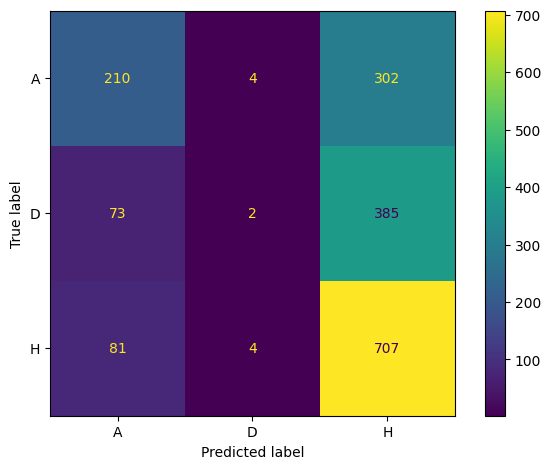

In [20]:
def evaluate_model(y_test, y_pred, target_names):
    print(classification_report(y_test, y_pred, target_names=target_names))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names)
    plt.tight_layout()
    plt.show()


evaluate_model(y_test, y_pred, TARGET_NAMES)

## RNN

#### a. Import stuff

In [ ]:
import keras

#### b. Transform data

In [42]:
def create_team_df(df: pd.DataFrame, team: str) -> pd.DataFrame:
    # Creates a dataframe for a given team
    games_with_team = df[(df.HomeTeam == team) | (df.AwayTeam == team)]
    team_df = games_with_team.drop(columns=["HomeTeam", "AwayTeam"])

    # Get opponents
    opponents = []

    for _, game in games_with_team.iterrows():
        if game.HomeTeam == team:
            opponents.append(game.AwayTeam)
        else:
            opponents.append(game.HomeTeam)

    team_df["Opponent"] = np.array(opponents)
    team_df["HomeMatch"] = games_with_team.HomeTeam.map(lambda t : t == team)

    return team_df


def get_team_dfs(df: pd.DataFrame) -> {str : pd.DataFrame}:
    # Gets a dataframe of matches for each team
    team_dfs = {}

    for team in df.HomeTeam.unique():
        team_dfs[team] = create_team_df(df, team)

    return team_dfs

#### c. Do the RNN

In [45]:
team_dfs = get_team_dfs(df)

## Other models

I'm going to try the data on a bunch of new models including:
- random forest
- logistic regression
- various neural networks

In [7]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# 
# 
# rfc = RandomForestClassifier(max_depth=3, random_state=42)
# rfc.fit(X=X_train, y=y_train)
# rfc_y_pred = rfc.predict(X_test)
# evaluate_model(y_test, rfc_y_pred, TARGET_NAMES)
# 
# 
# lgr = LogisticRegression(random_state=42)
# lgr.fit(X=X_train, y=y_train)
# lgr_y_pred = lgr.predict(X_test)
# evaluate_model(y_test, lgr_y_pred, TARGET_NAMES)

# Neural network nonsense

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

n_classes = 3

# Transform y format
le = LabelEncoder()
le.fit(TARGET_NAMES)

nn_y_train = to_categorical(le.fit_transform(y_train), num_classes=3)
nn_y_test = to_categorical(le.fit_transform(y_test), num_classes=3)

# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, nn_y_train, epochs=50, batch_size=32, use_multiprocessing=True) #, validation_data=(X_test, y_test))
nn_y_pred = model.predict(X_test)

# Evaluate the model
predicted_label_indices = np.argmax(nn_y_pred, axis=1)
predicted_labels = le.inverse_transform(predicted_label_indices)

2023-12-11 16:59:04.531335: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
124/124 [==============================] - 2s 5ms/step - loss: 1.2128 - accuracy: 0.3882
Epoch 2/50
124/124 [==============================] - 1s 4ms/step - loss: 1.0880 - accuracy: 0.4342
Epoch 3/50
124/124 [==============================] - 1s 4ms/step - loss: 1.0593 - accuracy: 0.4643
Epoch 4/50
124/124 [==============================] - 1s 4ms/step - loss: 1.0458 - accuracy: 0.4727
Epoch 5/50
124/124 [==============================] - 0s 4ms/step - loss: 1.0400 - accuracy: 0.4790
Epoch 6/50
124/124 [==============================] - 1s 4ms/step - loss: 1.0333 - accuracy: 0.4868
Epoch 7/50
124/124 [==============================] - 0s 4ms/step - loss: 1.0292 - accuracy: 0.4896
Epoch 8/50
124/124 [==============================] - 0s 3ms/step - loss: 1.0269 - accuracy: 0.4916
Epoch 9/50
124/124 [==============================] - 1s 4ms/step - loss: 1.0239 - accuracy: 0.5061
Epoch 10/50
124/124 [==============================] - 1s 4ms/step - loss: 1.0122 - accuracy: 0.5033

### And now we evaluate the above model

              precision    recall  f1-score   support

           A       0.40      0.55      0.47       278
           D       0.00      0.00      0.00       249
           H       0.55      0.72      0.62       461

    accuracy                           0.49       988
   macro avg       0.32      0.43      0.36       988
weighted avg       0.37      0.49      0.42       988



/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

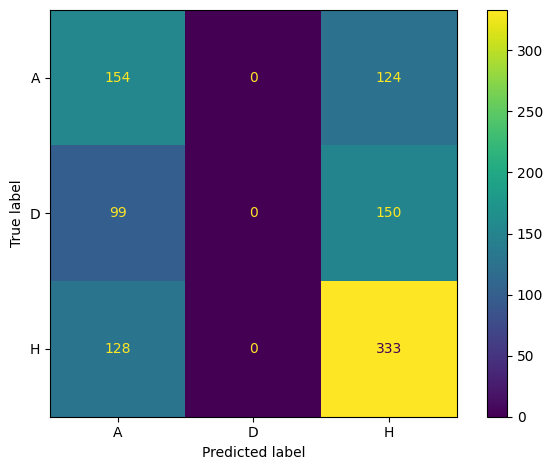

In [8]:
evaluate_model(y_test, predicted_labels, TARGET_NAMES)